VAE Interpolate

Interpolate from one latent space to another and viualize VAE

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision.transforms import ToTensor, Lambda, Grayscale, Compose, Resize
from torchvision import transforms
from torchvision.datasets import MNIST, ImageFolder
from matplotlib import pyplot as plt
import torchvision.utils as vutils
import torch.nn.functional as F

import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
#Change directories to point to your data!
data_path = '//content/drive/MyDrive/Copy of MNIST.zip/'
specfic_path = '/content/drive/MyDrive/Copy of MNIST.zip'
#!ls "$root_dir"
root_dir = "/content/data"


!unzip '//content/drive/MyDrive/Copy of MNIST.zip' -d "$root_dir"

Archive:  //content/drive/MyDrive/Copy of MNIST.zip
   creating: /content/data/MNIST/
  inflating: /content/data/MNIST/.DS_Store  
  inflating: /content/data/__MACOSX/MNIST/._.DS_Store  
   creating: /content/data/MNIST/processed/
   creating: /content/data/MNIST/raw/
  inflating: /content/data/MNIST/processed/training.pt  
  inflating: /content/data/MNIST/processed/test.pt  
  inflating: /content/data/MNIST/raw/t10k-images-idx3-ubyte  
  inflating: /content/data/MNIST/raw/t10k-labels-idx1-ubyte  
  inflating: /content/data/MNIST/raw/train-images-idx3-ubyte  
  inflating: /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz  
  inflating: /content/data/MNIST/raw/train-images-idx3-ubyte.gz  
  inflating: /content/data/MNIST/raw/train-labels-idx1-ubyte.gz  
  inflating: /content/data/MNIST/raw/train-labels-idx1-ubyte  
  inflating: /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz  


In [17]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

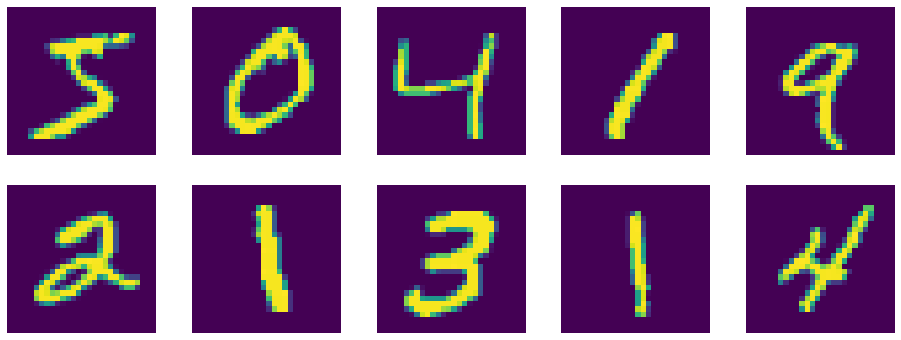

In [20]:
# The MNIST dataset is the handwritten dataset.
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = data.dataset[i]
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')

VAE Model

In [21]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device) # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [22]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 128)
        self.linear2 = nn.Linear(128, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [23]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

Training the model

In [24]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()

        print(f'====> Epoch: {epoch} Average loss: {loss / len(data.dataset):.4f}')
            
    return autoencoder

In [26]:
latent_dims=2

vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train(vae, data)


====> Epoch: 0 Average loss: 0.0722
====> Epoch: 1 Average loss: 0.0668
====> Epoch: 2 Average loss: 0.0672
====> Epoch: 3 Average loss: 0.0646
====> Epoch: 4 Average loss: 0.0677
====> Epoch: 5 Average loss: 0.0700
====> Epoch: 6 Average loss: 0.0647
====> Epoch: 7 Average loss: 0.0618
====> Epoch: 8 Average loss: 0.0684
====> Epoch: 9 Average loss: 0.0647


In [27]:
vae.eval

<bound method Module.eval of VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=784, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=2, bias=True)
    (linear3): Linear(in_features=128, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=2, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=784, bias=True)
  )
)>

In [28]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

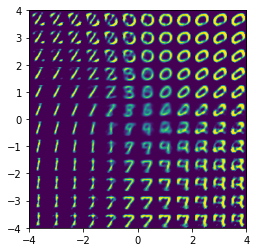

In [31]:
plot_reconstructed(vae, r0=(-4, 4), r1=(-4, 4))

Visualising latent space

In [32]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

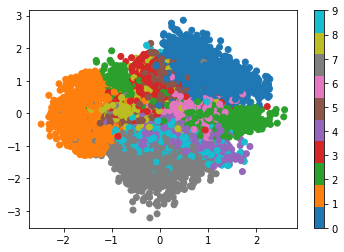

In [33]:
plot_latent(vae, data)

Interpolate in Latent space

In [34]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [35]:
x, y = data.__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

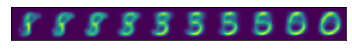

In [36]:
interpolate(vae, x_1, x_2, n=10)